In [1]:
"""
    Instruções:
        1- Responda as perguntas listadas no README.md;
        2- Faça as análises que julgar necessárias e deixe os resultados de suas análises plotadas no notebook.
"""

'\n    Instruções:\n        1- Responda as perguntas listadas no README.md;\n        2- Faça as análises que julgar necessárias e deixe os resultados de suas análises plotadas no notebook.\n'

In [4]:
"""ÁREA TOTAL DE DESMATAMENTO"""

import geopandas as gpd
import pandas as pd
from datetime import datetime

def analisar_desmatamento(file_path):
    # Carregar o arquivo GeoJSON
    gdf = gpd.read_file(file_path)

    # Converter as datas para o formato datetime
    gdf['Data Inicial'] = pd.to_datetime(gdf['Data Inicial'], format='%d/%m/%Y', errors='coerce')
    gdf['Data Final'] = pd.to_datetime(gdf['Data Final'], format='%d/%m/%Y', errors='coerce')

    # Definir os períodos de agosto e setembro de 2022
    agosto_inicio = datetime(2022, 8, 1)
    agosto_final = datetime(2022, 8, 31)
    setembro_inicio = datetime(2022, 9, 1)
    setembro_final = datetime(2022, 9, 30)

    # Filtrar os dados para agosto e setembro de 2022
    gdf_agosto = gdf[(gdf['Data Final'] >= agosto_inicio) & (gdf['Data Final'] <= agosto_final)]
    gdf_setembro = gdf[(gdf['Data Final'] >= setembro_inicio) & (gdf['Data Final'] <= setembro_final)]

    # Calcular a área total desmatada em hectares (1 hectare = 10.000 metros quadrados)
    area_total_agosto = round(gdf_agosto['geometry'].area.sum() / 10000)
    area_total_setembro = round(gdf_setembro['geometry'].area.sum() / 10000)

    # Criar um DataFrame com os valores de agosto e setembro
    df = pd.DataFrame({'Área Desmatada em Agosto de 2022(ha)': [area_total_agosto],
                       'Área Desmatada em Setembro de 2022(ha)': [area_total_setembro]})

    return df

# Caminho para o arquivo GeoJSON
file_path = 'dados/focos-desmatamento-mg.geojson'

# Executar a função para obter o DataFrame
df_resultado = analisar_desmatamento(file_path)

# Salvar o DataFrame em um arquivo CSV
df_resultado.to_csv('dados/desmatamento_total_agosto_setembro.csv', index=False)

print("#############  ÁREA TOTAL DE DESMATAMENTO DO ESTADO DE MINAS GERAIS  #############\n")
print(df_resultado)



#############  ÁREA TOTAL DE DESMATAMENTO DO ESTADO DE MINAS GERAIS  #############

   Área Desmatada em Agosto de 2022(ha)  \
0                                  7875   

   Área Desmatada em Setembro de 2022(ha)  
0                                   28605  


In [48]:
import geopandas as gpd
import pandas as pd
from datetime import datetime

# Carregar o arquivo GeoJSON
file_path = 'dados/focos-desmatamento-mg.geojson'
gdf = gpd.read_file(file_path)

# Converter as datas para o formato datetime
gdf['Data Inicial'] = pd.to_datetime(gdf['Data Inicial'], format='%d/%m/%Y', errors='coerce')
gdf['Data Final'] = pd.to_datetime(gdf['Data Final'], format='%d/%m/%Y', errors='coerce')

# Definir os períodos de agosto e setembro de 2022
agosto_inicio = datetime(2022, 8, 1)
agosto_final = datetime(2022, 8, 31)
setembro_inicio = datetime(2022, 9, 1)
setembro_final = datetime(2022, 9, 30)

# Filtrar os dados para agosto e setembro de 2022
gdf_periodo = gdf[(gdf['Data Final'] >= agosto_inicio) & (gdf['Data Final'] <= setembro_final)]

# Agrupar por bioma e calcular a área total desmatada em km² (1 km² = 10^6 metros quadrados)
area_por_bioma = gdf_periodo.groupby('Bioma')['geometry'].apply(lambda x: x.area.sum()) / 10**6
area_por_bioma_df = area_por_bioma.reset_index(name='Km2').sort_values(by='Km2', ascending=True)
area_por_bioma_df.to_csv('dados/desmatamento_por_bioma.csv', index=False)
print(" Área total desmatada em km² no estado de Minas Gerais em todo o período fornecido (ago/set de 2022) ")
print(area_por_bioma_df)

 Área total desmatada em km² no estado de Minas Gerais em todo o período fornecido (ago/set de 2022) 
            Bioma         Km2
0        Caatinga   57.680346
2  Mata Atlântica   83.407479
1         Cerrado  223.712629


In [46]:
#### verificando a interseção dos polígonos de desmatamento com os polígonos dos municípios

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

def main():
    # Carregar os arquivos
    caminho_municipios = 'dados/pib_municipios_with_geo.csv'
    caminho_desmatamento = 'dados/focos-desmatamento-mg.geojson'

    # Lendo os arquivos
    dados_municipios = pd.read_csv(caminho_municipios)
    dados_desmatamento = gpd.read_file(caminho_desmatamento)

    # Convertendo o DataFrame de municípios para um GeoDataFrame
    gdf_municipios = gpd.GeoDataFrame(dados_municipios, geometry=gpd.GeoSeries.from_wkt(dados_municipios['geometry']))
    gdf_municipios.set_crs(epsg=31983, inplace=True)

    # Filtrando os dados de desmatamento para agosto e setembro de 2022
    dados_desmatamento['Data Inicial'] = pd.to_datetime(dados_desmatamento['Data Inicial'], format='%d/%m/%Y', errors='coerce')
    dados_desmatamento['Data Final'] = pd.to_datetime(dados_desmatamento['Data Final'], format='%d/%m/%Y', errors='coerce')
    dados_desmatamento_filtrados = dados_desmatamento[
        (dados_desmatamento['Data Inicial'] >= '2022-08-01') &
        (dados_desmatamento['Data Final'] <= '2022-09-30')
    ]

    # Realizando a operação de interseção para associar cada foco de desmatamento ao município correspondente
    intersecao = gpd.overlay(dados_desmatamento_filtrados, gdf_municipios, how='intersection')

    # Calculando a área de cada foco de desmatamento em km²
    intersecao['area_km2'] = intersecao['geometry'].area / 10**6

    # Convertendo o número do mês para o nome do mês
    intersecao['Mes'] = intersecao['Data Inicial'].dt.month
    intersecao['Mes'] = intersecao['Mes'].map({8: 'agosto', 9: 'setembro'})

    # Agrupando os dados por município e mês, e somando a área de desmatamento
    resultado = intersecao.groupby(['Municípios', 'Mes'])['area_km2'].sum().reset_index()

    # Ordenando os resultados em ordem ascendente por área desmatada
    resultado_ordenado = resultado.sort_values(by='area_km2', ascending=False).reset_index(drop=True)

    return resultado_ordenado

# Executando a função principal e armazenando os resultados
resultado_final = main()
resultado_final.to_csv('dados/desmatamento_por_municipio.csv', index=False)
resultado_final



,Municípios,Mes,area_km2
0,Paracatu,setembro,13.255922
1,Santa Vitória,setembro,10.766537
2,Uberaba,setembro,7.583420
3,Santa Juliana,setembro,7.498311
4,Jaíba,setembro,7.340608
...,...,...,...
377,Joanésia,agosto,0.007775
378,Boa Esperança,agosto,0.001233
379,Piranguinho,setembro,0.000746
380,Cachoeira da Prata,setembro,0.000476


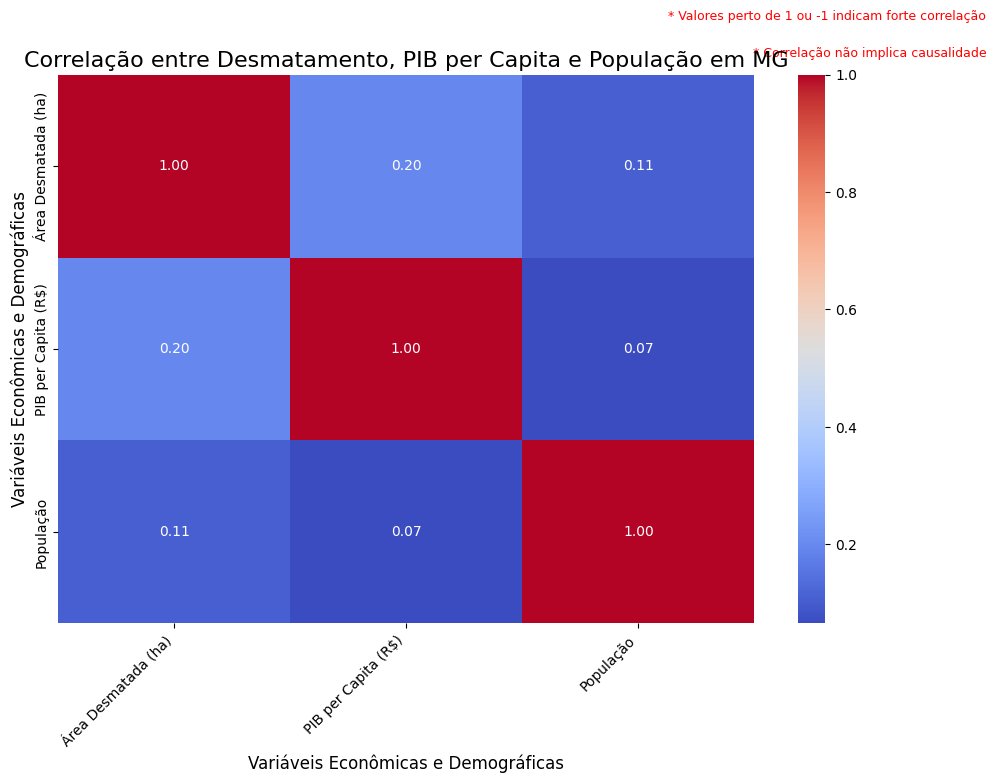

In [39]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar os dados dos arquivos fornecidos
pib_municipios = pd.read_csv('dados/pib_municipios_with_geo.csv')
focos_desmatamento = gpd.read_file('dados/focos-desmatamento-mg.geojson')

# Convertendo a coluna 'geometry' do dataframe pib_municipios para um GeoDataFrame
gdf_municipios = gpd.GeoDataFrame(pib_municipios, geometry=gpd.GeoSeries.from_wkt(pib_municipios['geometry']))

# Certificar que ambos os GeoDataFrames estão no mesmo sistema de referência de coordenadas (CRS)
gdf_municipios = gdf_municipios.set_crs(focos_desmatamento.crs)

# Realizando a operação de interseção para associar cada foco de desmatamento ao município correspondente
intersecao = gpd.overlay(focos_desmatamento, gdf_municipios, how='intersection')

# Agora, para realizar a análise de correlação, precisamos agregar os dados de desmatamento por município
intersecao['area_desmatada_hectares'] = intersecao['geometry'].area / 10000  # Convertendo de metros quadrados para hectares

# Agregando os dados de desmatamento por município
dados_agregados = intersecao.groupby('Municípios').agg({
    'area_desmatada_hectares': 'sum',
    'PIB per capita': 'first',  # Assumindo que o PIB per capita é o mesmo para todos os registros do mesmo município
    'População': 'first'        # Assumindo que a população é a mesma para todos os registros do mesmo município
}).reset_index()

# Calculando a correlação
correlacao = dados_agregados[['area_desmatada_hectares', 'PIB per capita', 'População']].corr()

# Gerando o mapa de calor para a matriz de correlação com rótulos mais descritivos
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, fmt=".2f", cmap='coolwarm')

# Adicionando títulos e rótulos mais explicativos
plt.title("Correlação entre Desmatamento, PIB per Capita e População em MG", fontsize=16)
plt.xlabel("Variáveis Econômicas e Demográficas", fontsize=12)
plt.ylabel("Variáveis Econômicas e Demográficas", fontsize=12)

# Definindo os nomes dos ticks para serem mais descritivos
tick_labels = ['Área Desmatada (ha)', 'PIB per Capita (R$)', 'População']
plt.xticks(plt.xticks()[0], tick_labels, rotation=45, ha='right', fontsize=10)
plt.yticks(plt.yticks()[0], tick_labels, fontsize=10)

# Adicionando comentários
plt.text(4, -0.1, "* Correlação não implica causalidade", fontsize=9, ha='right', color='red')
plt.text(4, -0.3, "* Valores perto de 1 ou -1 indicam forte correlação", fontsize=9, ha='right', color='red')

plt.tight_layout()  # Ajusta o layout para não cortar os rótulos
plt.show()
